In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
%cd /content/gdrive/My Drive/data/Unet_train/deeplabv3

/content/gdrive/My Drive/data/Unet_train/deeplabv3


In [58]:
#!pip install tensorflow-gpu==2.3
# !pip install Keras==2.2.4
!pip install pydensecrf

     |████████████████████████████████| 1.0MB 4.7MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153639 sha256=1be6e6f470c4e1bf864066664b3835a9bd24e875934f25de86a33ab73b061efb
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [71]:
# -*- coding: utf-8 -*-

""" Deeplabv3+ model for Keras.
This model is based on TF repo:
https://github.com/tensorflow/models/tree/master/research/deeplab
On Pascal VOC, original model gets to 84.56% mIOU
Now this model is only available for the TensorFlow backend,
due to its reliance on `SeparableConvolution` layers, but Theano will add
this layer soon.
MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras
# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import tensorflow as tf

if tf.__version__[0] == "2":
    from tensorflow.keras.models import Model
    from tensorflow.keras.activations import relu
    from tensorflow.keras.layers import Layer, InputSpec, Conv2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D, Lambda, AveragePooling2D, Input, Activation, Concatenate, Add, Reshape, BatchNormalization, Dropout 
    from tensorflow.keras.utils import get_source_inputs
    from tensorflow.keras import backend as K
    print('2.0')
else:
    from keras.models import Model
    from keras.activations import relu
    from keras.layers import Conv2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D, Lambda, AveragePooling2D, Input, Activation, Concatenate, Add, Reshape, BatchNormalization, Dropout 
    from keras.engine import Layer, InputSpec
    from keras.engine.topology import get_source_inputs
    from keras import backend as K

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"



def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand
        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        #x = Lambda(lambda x: relu(x, max_value=6.))(x)
        x = Lambda(lambda x: relu(x, max_value=6.), name=prefix + 'expand_relu')(x)
        #x = Activation(relu(x, max_value=6.), name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)
    #x = Activation(relu(x, max_value=6.), name=prefix + 'depthwise_relu')(x)
    x = Lambda(lambda x: relu(x, max_value=6.), name=prefix + 'depthwise_relu')(x)

    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, infer = False,
              input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1.):
    
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc)
            or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        classes: number of desired classes. If classes != 21,
            last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """
        
    if not (weights in {'pascal_voc', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `pascal_voc` '
                         '(pre-trained on PASCAL VOC)')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    
    
    batches_input = Lambda(lambda x: x/127.5 - 1)(img_input)

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)
        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(batches_input)
            
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(batches_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        
        x = Lambda(lambda x: relu(x, max_value=6.))(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
        
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    
    b4 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x,size=[int(np.ceil(input_shape[0]/OS)), int(np.ceil(input_shape[1]/OS))]))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])
        
    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block

        x = Lambda(lambda x: K.tf.image.resize_bilinear(x,size=(int(np.ceil(input_shape[0]/4)), int(np.ceil(input_shape[1]/4)))))(x)
        
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if classes == 21:
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'
    
    
    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    x = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x,size=(input_shape[0],input_shape[1])))(x)
    if infer:
        x = Activation('softmax')(x)
    else:
        x = Reshape((input_shape[0]*input_shape[1], classes)) (x)
        x = Activation('softmax')(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='deeplabv3p')


    return model

2.0


In [72]:
model= Deeplabv3()

In [30]:
model.summary()

Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, 512, 512, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         lambda_37[0][0]                  
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
_________________________________________________________________________________________

In [74]:
model.load_weights('/content/gdrive/My Drive/data/Unet_train/deeplabv3/weights/mobilenetv2_original.h5')

In [75]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [76]:
def load(path, size=512):
    img= cv2.resize(cv2.imread(path),(size,size))
    return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), axis=0)

In [91]:
img= load('/content/gdrive/My Drive/data/Photo/p1.jpg')
img.shape

(1, 512, 512, 3)

In [92]:
img2=model.predict(img)

In [93]:
img2.shape, 512*512*1*21

((1, 262144, 21), 5505024)

In [111]:
def show(path):
  img= load(path)
  img2=model.predict(img)
  img2= img2.reshape(512, 512, 21)

  f, ax= plt.subplots(1, 2, figsize=(17,9))
  ax[0].imshow(img[0], aspect='auto')
  ax[1].imshow(img2[:, :, 15], cmap='gray', aspect='auto')
  plt.show()

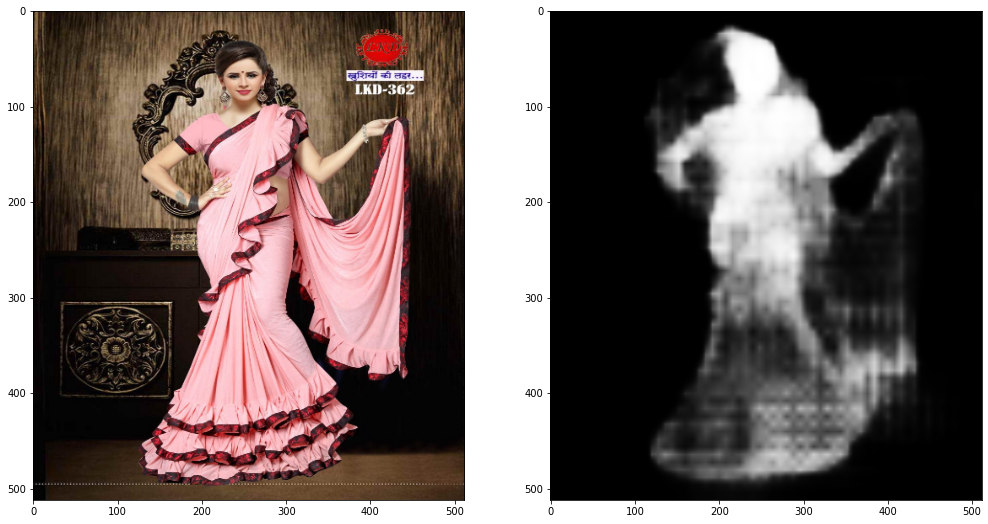

In [112]:
show('/content/gdrive/My Drive/data/Photo/WhatsApp Image 2019-01-26 at 6.59.29 PM-1.jpeg')

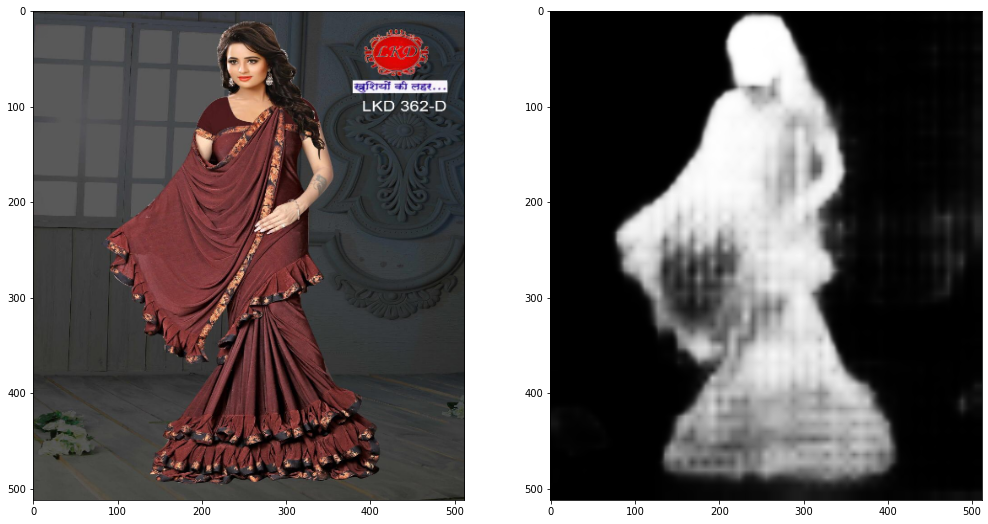

In [113]:
show('/content/gdrive/My Drive/data/Photo/WhatsApp Image 2019-01-26 at 6.59.30 PM(1)-1.jpeg')

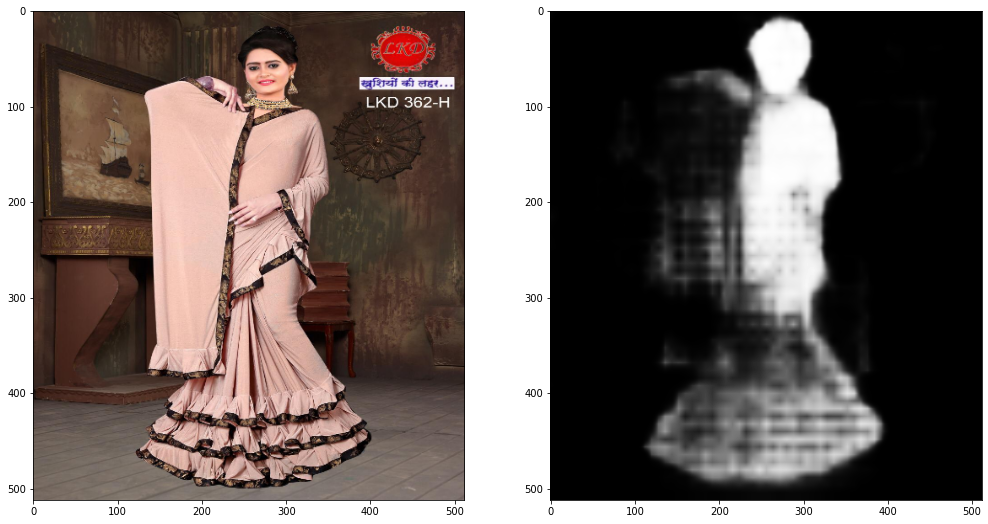

In [114]:
show('/content/gdrive/My Drive/data/Photo/WhatsApp Image 2019-01-26 at 6.59.31 PM(1)-1.jpeg')

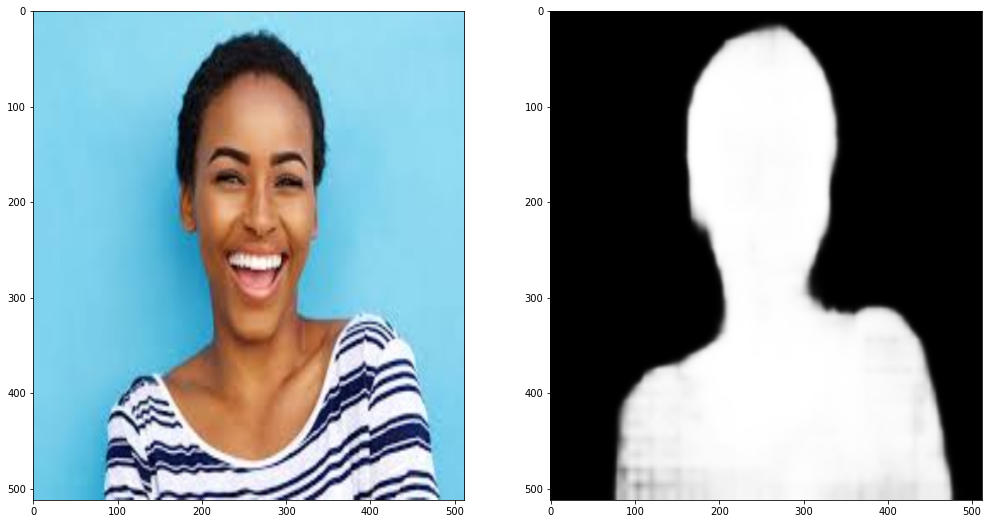

In [117]:
show('/content/gdrive/My Drive/data/Photo/p4.jpg')

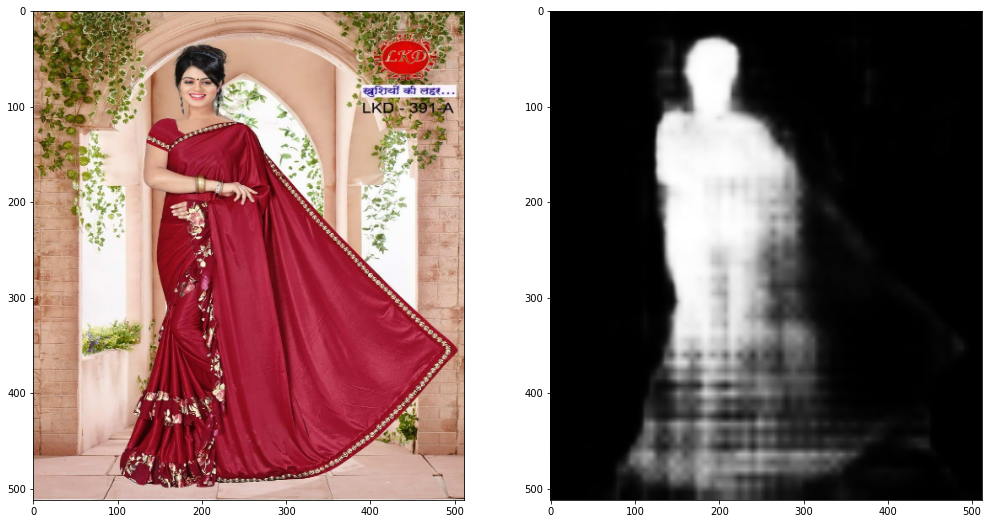

In [116]:
show('/content/gdrive/My Drive/data/Photo/WhatsApp Image 2019-01-29 at 12.23.53 PM-1.jpeg')